In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/롤 데이터 분석/data/data.csv")
data

,role,teamPosition,goldPerMinute,killParticipation,visionScorePerMinute,game_duration,pings.per.min,objectDealt.per.min,championDealt.per.min,tankorheals.per.min,cs.per.min,KDA,changed_rank
0,DUO,MIDDLE,340.558038,0.281250,0.812030,22.883333,2.228696,188.302986,416.547706,332.818645,4.806992,9.000000,1259.059313
1,SUPPORT,UTILITY,277.992362,0.368421,1.847087,26.150000,1.070746,253.575526,534.378585,427.227533,1.070746,1.750000,1260.650803
2,SUPPORT,UTILITY,383.570747,0.533333,2.617196,21.633333,1.340524,267.134052,731.463790,334.530046,1.063174,8.000000,1260.123472
3,SUPPORT,UTILITY,296.582688,0.619048,2.525915,43.000000,1.511628,146.581395,690.744186,649.348837,1.302326,2.888889,1261.719654
4,SUPPORT,UTILITY,328.347939,0.380952,2.965757,26.750000,1.532710,243.813084,407.214953,553.532710,1.495327,2.666667,1259.984844
...,...,...,...,...,...,...,...,...,...,...,...,...,...
280307,DUO,BOTTOM,475.414011,0.818182,1.088921,15.566667,0.449679,48.886510,692.955032,429.122056,7.708779,9.000000,1728.534431
280308,CARRY,BOTTOM,404.748984,0.428571,1.130824,30.550000,0.360065,208.936170,499.148936,664.877250,7.888707,3.000000,1731.683667
280309,CARRY,BOTTOM,390.469784,0.625000,1.110857,26.683333,0.637102,268.069956,476.514678,841.086821,7.307933,1.875000,1726.496888
280310,SOLO,BOTTOM,315.656164,0.294118,1.083939,28.816667,0.277617,218.727588,201.619433,664.303065,7.252747,0.833333,1733.348616


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280312 entries, 0 to 280311
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   role                   280312 non-null  object 
 1   teamPosition           280312 non-null  object 
 2   goldPerMinute          280312 non-null  float64
 3   killParticipation      280312 non-null  float64
 4   visionScorePerMinute   280312 non-null  float64
 5   game_duration          280312 non-null  float64
 6   pings.per.min          280312 non-null  float64
 7   objectDealt.per.min    280312 non-null  float64
 8   championDealt.per.min  280312 non-null  float64
 9   tankorheals.per.min    280312 non-null  float64
 10  cs.per.min             280312 non-null  float64
 11  KDA                    280312 non-null  float64
 12  changed_rank           280312 non-null  float64
dtypes: float64(11), object(2)
memory usage: 27.8+ MB


In [ ]:
type(data)

pandas.core.frame.DataFrame

In [ ]:
# 회귀 -> 분류 티어당, 총 6개로 압축
# 980.9229 ~ 1386.7672 는 BRONZE
# 1386.7672 ~ 1792.6115는 SILVER
# 1792.6115 ~ 2198.4558는 GOLD
# 2198.4558 ~ 2604.3001는 PLATINUM
# 2604.3001 ~ 3010.1444 는 EMERALD
# 3010.1444 ~ 3415.9887 는 DIAMOND

In [ ]:
data['tier'] = data['changed_rank'].apply(lambda x: 'BRONZE' if 980.9229 <= x <= 1386.7672
                                          else 'SILVER' if 1386.7672 < x <= 1792.6115
                                          else 'GOLD' if 1792.6115 < x <= 2198.4558
                                          else 'PLATINUM' if 2198.4558 < x <= 2604.3001
                                          else 'EMERALD' if 2604.3001 < x <= 3010.1444
                                          else 'DIAMOND')
data = data.drop(['changed_rank'],axis=1)
data

,role,teamPosition,goldPerMinute,killParticipation,visionScorePerMinute,game_duration,pings.per.min,objectDealt.per.min,championDealt.per.min,tankorheals.per.min,cs.per.min,KDA,tier
0,DUO,MIDDLE,340.558038,0.281250,0.812030,22.883333,2.228696,188.302986,416.547706,332.818645,4.806992,9.000000,BRONZE
1,SUPPORT,UTILITY,277.992362,0.368421,1.847087,26.150000,1.070746,253.575526,534.378585,427.227533,1.070746,1.750000,BRONZE
2,SUPPORT,UTILITY,383.570747,0.533333,2.617196,21.633333,1.340524,267.134052,731.463790,334.530046,1.063174,8.000000,BRONZE
3,SUPPORT,UTILITY,296.582688,0.619048,2.525915,43.000000,1.511628,146.581395,690.744186,649.348837,1.302326,2.888889,BRONZE
4,SUPPORT,UTILITY,328.347939,0.380952,2.965757,26.750000,1.532710,243.813084,407.214953,553.532710,1.495327,2.666667,BRONZE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
280307,DUO,BOTTOM,475.414011,0.818182,1.088921,15.566667,0.449679,48.886510,692.955032,429.122056,7.708779,9.000000,SILVER
280308,CARRY,BOTTOM,404.748984,0.428571,1.130824,30.550000,0.360065,208.936170,499.148936,664.877250,7.888707,3.000000,SILVER
280309,CARRY,BOTTOM,390.469784,0.625000,1.110857,26.683333,0.637102,268.069956,476.514678,841.086821,7.307933,1.875000,SILVER
280310,SOLO,BOTTOM,315.656164,0.294118,1.083939,28.816667,0.277617,218.727588,201.619433,664.303065,7.252747,0.833333,SILVER


In [ ]:
data.value_counts('tier')

,count
tier,
EMERALD,51786
GOLD,48431
SILVER,47519
PLATINUM,45619
BRONZE,44768
DIAMOND,42189


In [ ]:
list = ['role','teamPosition']
list

['role', 'teamPosition']

In [ ]:
data = pd.get_dummies(data,columns=list)
data

,goldPerMinute,killParticipation,visionScorePerMinute,game_duration,pings.per.min,objectDealt.per.min,championDealt.per.min,tankorheals.per.min,cs.per.min,KDA,...,role_CARRY,role_DUO,role_NONE,role_SOLO,role_SUPPORT,teamPosition_BOTTOM,teamPosition_JUNGLE,teamPosition_MIDDLE,teamPosition_TOP,teamPosition_UTILITY
0,340.558038,0.281250,0.812030,22.883333,2.228696,188.302986,416.547706,332.818645,4.806992,9.000000,...,False,True,False,False,False,False,False,True,False,False
1,277.992362,0.368421,1.847087,26.150000,1.070746,253.575526,534.378585,427.227533,1.070746,1.750000,...,False,False,False,False,True,False,False,False,False,True
2,383.570747,0.533333,2.617196,21.633333,1.340524,267.134052,731.463790,334.530046,1.063174,8.000000,...,False,False,False,False,True,False,False,False,False,True
3,296.582688,0.619048,2.525915,43.000000,1.511628,146.581395,690.744186,649.348837,1.302326,2.888889,...,False,False,False,False,True,False,False,False,False,True
4,328.347939,0.380952,2.965757,26.750000,1.532710,243.813084,407.214953,553.532710,1.495327,2.666667,...,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280307,475.414011,0.818182,1.088921,15.566667,0.449679,48.886510,692.955032,429.122056,7.708779,9.000000,...,False,True,False,False,False,True,False,False,False,False
280308,404.748984,0.428571,1.130824,30.550000,0.360065,208.936170,499.148936,664.877250,7.888707,3.000000,...,True,False,False,False,False,True,False,False,False,False
280309,390.469784,0.625000,1.110857,26.683333,0.637102,268.069956,476.514678,841.086821,7.307933,1.875000,...,True,False,False,False,False,True,False,False,False,False
280310,315.656164,0.294118,1.083939,28.816667,0.277617,218.727588,201.619433,664.303065,7.252747,0.833333,...,False,False,False,True,False,True,False,False,False,False


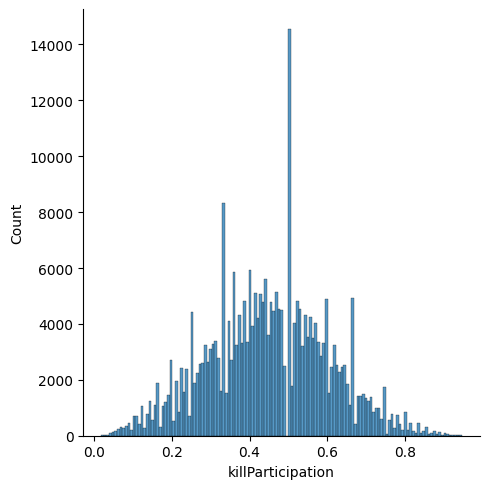

In [ ]:
sns.displot(data['killParticipation'])

<Axes: ylabel='killParticipation'>

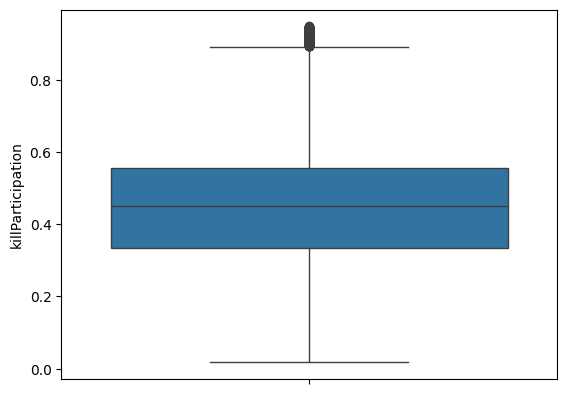

In [ ]:
sns.boxplot(data['killParticipation'])

In [ ]:
tier_order = ['BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'EMERALD', 'DIAMOND']

In [ ]:
data.columns

Index(['goldPerMinute', 'killParticipation', 'visionScorePerMinute',
       'game_duration', 'pings.per.min', 'objectDealt.per.min',
       'championDealt.per.min', 'tankorheals.per.min', 'cs.per.min', 'KDA',
       'tier', 'role_CARRY', 'role_DUO', 'role_NONE', 'role_SOLO',
       'role_SUPPORT', 'teamPosition_BOTTOM', 'teamPosition_JUNGLE',
       'teamPosition_MIDDLE', 'teamPosition_TOP', 'teamPosition_UTILITY'],
      dtype='object')

In [ ]:
len(data.columns)

21

<ipython-input-34-842ce0789977>:14: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  plt.tight_layout()
<ipython-input-34-842ce0789977>:14: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  plt.tight_layout()
<ipython-input-34-842ce0789977>:14: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


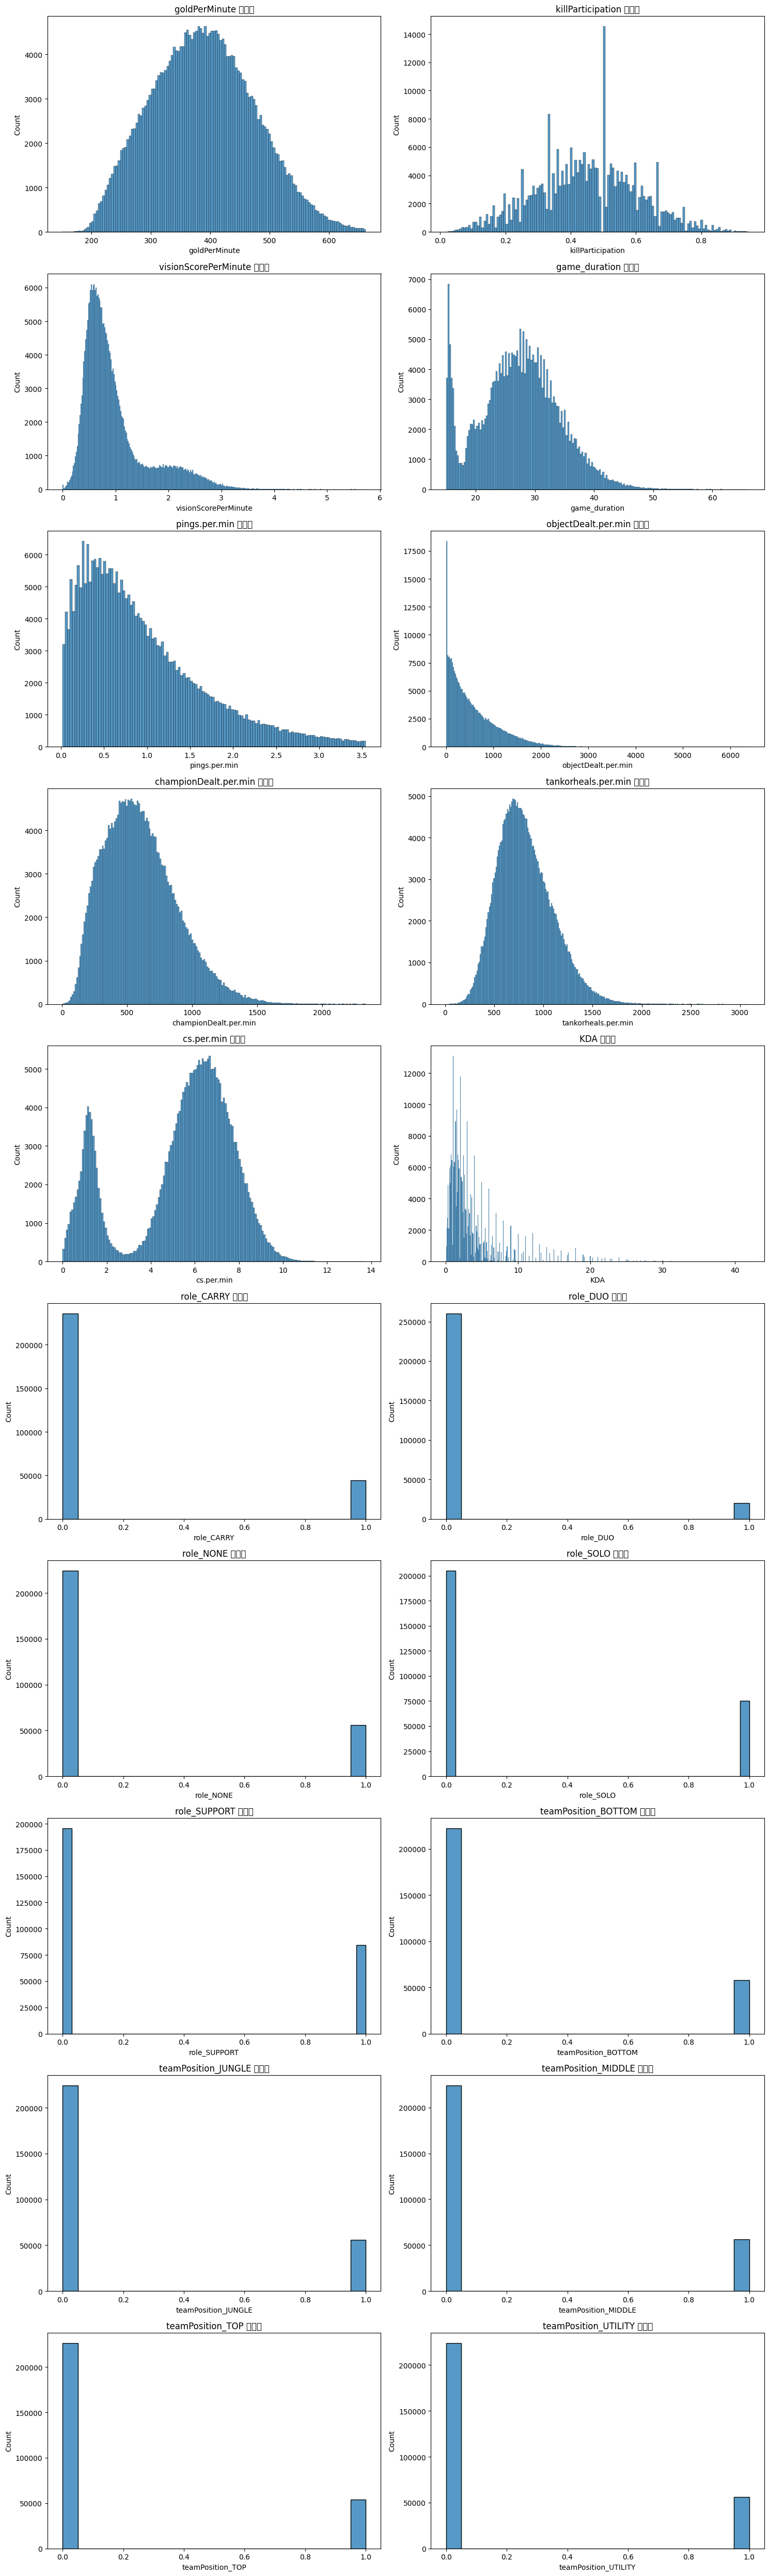

In [ ]:
variables = [col for col in data.columns if col != 'tier']
fig, axes = plt.subplots(10, 2, figsize=(15, 10 * 5))
axes = axes.flatten()


for idx, var in enumerate(variables):
    sns.histplot(data[var], ax=axes[idx])
    axes[idx].set_title(f'{var}')


for idx in range(len(variables), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()



In [ ]:
# 데이터 불균형 문제
# 정확도는 높지만 손실 함수가 줄어들지 않는다면,
# 드문 클래스에 대한 손실이 크기 때문에 전체 손실의 감소 저하

# 오버샘플링, 언더샘플링, 또는 클래스 가중치 조정.
# 생성형 AI 모델을 사용한 데이터 증강

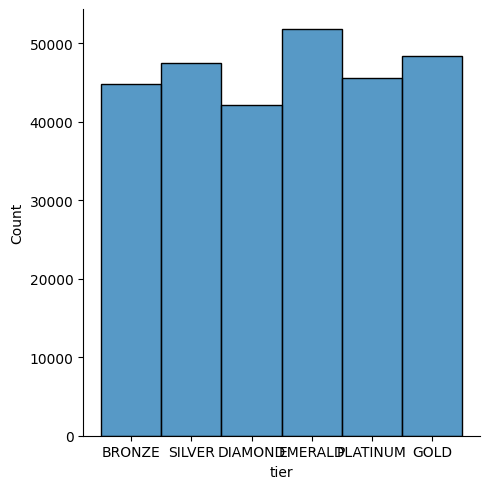

In [ ]:
sns.displot(data['tier'])

<Axes: xlabel='objectDealt.per.min', ylabel='Count'>

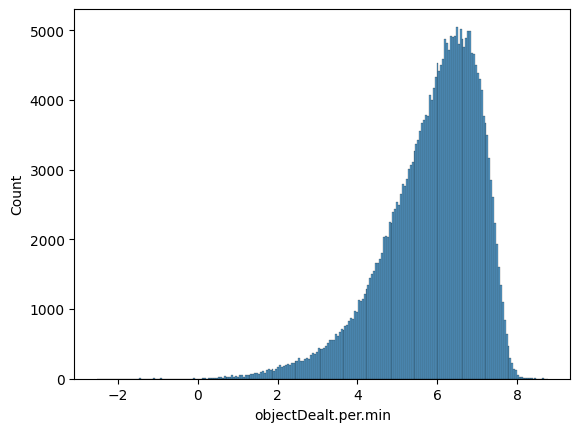

In [ ]:
sns.histplot(np.log(data['objectDealt.per.min']))

In [ ]:
# 'BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'EMERALD', 'DIAMOND'
bronze_data = data[data['tier'] == 'BRONZE']
silver_data = data[data['tier'] == 'SILVER']
gold_data = data[data['tier'] == 'GOLD']
platinum_data = data[data['tier'] == 'PLATINUM']
emerald_data = data[data['tier'] == 'EMERALD']
diamond_data = data[data['tier'] == 'DIAMOND']

<Axes: xlabel='killParticipation', ylabel='Count'>

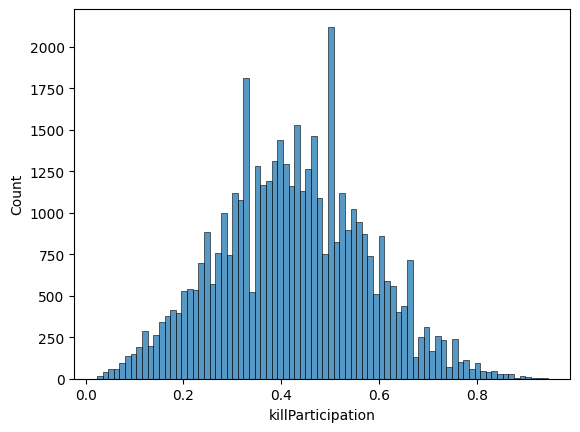

In [ ]:
sns.histplot((bronze_data['killParticipation']))

<Axes: xlabel='killParticipation', ylabel='Count'>

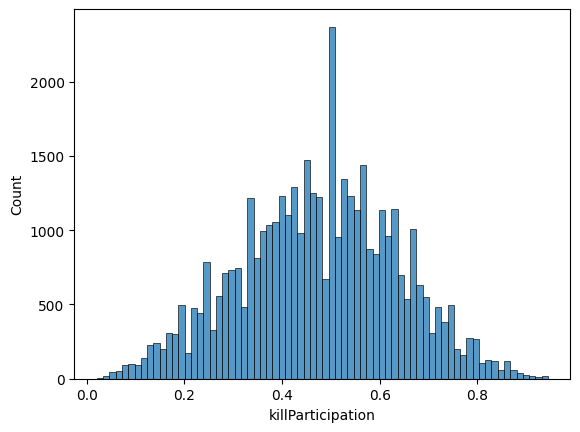

In [ ]:
sns.histplot((diamond_data['killParticipation']))

In [ ]:
## cs 양봉형 처리

## data['cs_per_min_binned'] = pd.cut(data['cs.per.min'], bins=[0, 2, 4, 6, 8, 10], labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']) 아예 범주로 변환 원핫인코딩?

## 서포터가 아닌데 cs.per.min 값이 2.5보다 작은 값들 개수만 삭제하기

228
teamPosition_UTILITY
False    224085
True      56227
Name: count, dtype: int64


In [ ]:
# 서포터가 아니면서 cs.per.min 값이 2.5 이하인 데이터
condition_to_drop = (data['teamPosition_UTILITY'] == 0) & (data['cs.per.min'] <= 2.5)

index_to_drop = data[condition_to_drop].index

# 해당 인덱스의 삭제
data = data.drop(index_to_drop)

print(data.shape)

(280084, 21)


In [ ]:
# 너무 짧은 게임 시간
len(data[data['game_duration'] <= 17])

26295

In [ ]:
np.random.seed(2023)

# game_duration이 17 이하인 데이터 필터링
filtered_data = data[data['game_duration'] <= 17]

# 랜덤한 10,000개의 샘플 추출
sampled_data = filtered_data.sample(n=4000, random_state=2023)

# filtered_data를 드롭하고 sampled_data로 대체
data = pd.concat([data[~data.index.isin(filtered_data.index)], sampled_data])

print(f"Updated data shape: {data.shape}")

Updated data shape: (257789, 21)


<Axes: xlabel='game_duration', ylabel='Count'>

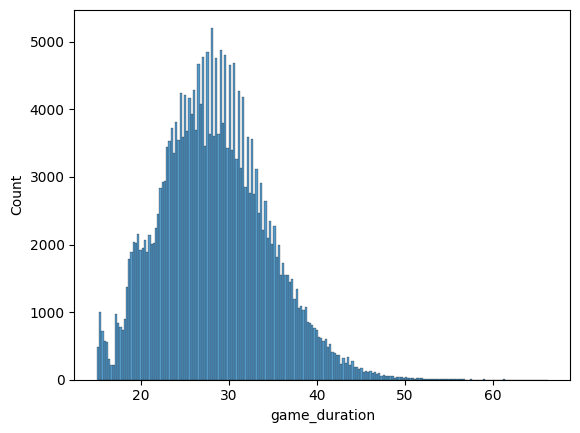

In [ ]:
sns.histplot((data['game_duration']))

In [ ]:
len(data['tier'])

257789

<Axes: xlabel='KDA', ylabel='Count'>

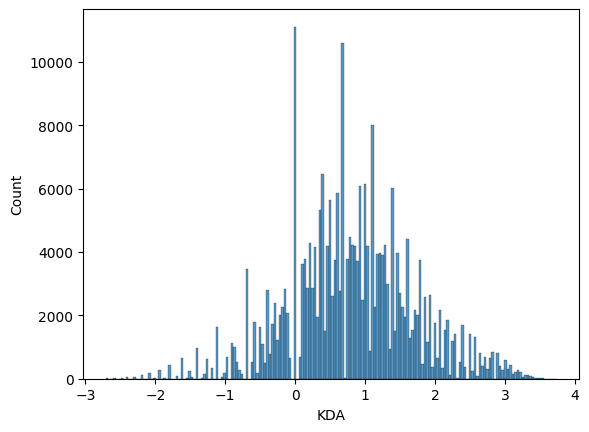

In [ ]:
sns.histplot(np.log(data['KDA']))

<Axes: xlabel='KDA', ylabel='Count'>

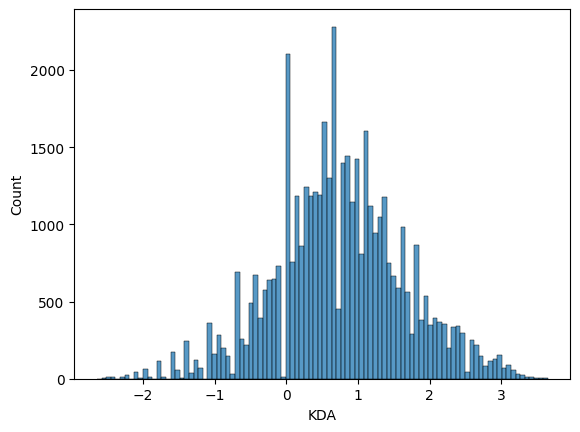

In [ ]:
sns.histplot(np.log(bronze_data['KDA']))

<Axes: xlabel='KDA', ylabel='Count'>

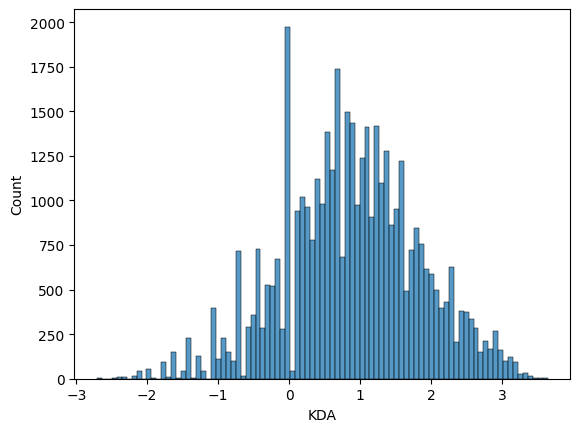

In [ ]:
sns.histplot(np.log(diamond_data['KDA']))

Maximum count: 11110
Bin range with maximum count: (-0.022333609691552514, 0.01347594486058945)


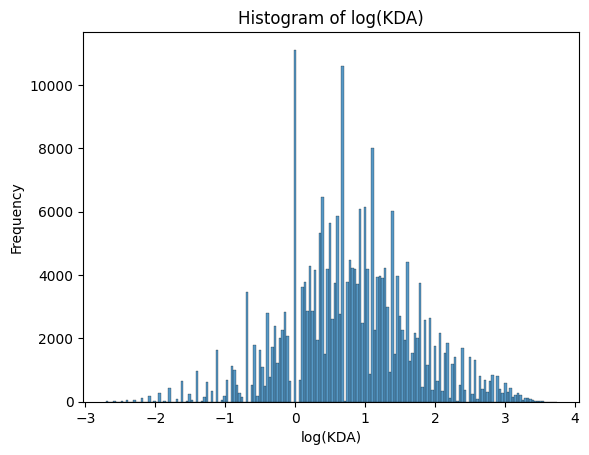

In [ ]:
# 로그 변환
log_kda = np.log(data['KDA'])

# 히스토그램 계산
counts, bin_edges = np.histogram(log_kda, bins='auto')

# 최대 빈도 수와 해당 빈도가 발생하는 도수 범위 찾기
max_count = counts.max()
max_index = counts.argmax()
max_bin_range = (bin_edges[max_index], bin_edges[max_index + 1])

print(f"Maximum count: {max_count}")
print(f"Bin range with maximum count: {max_bin_range}")

# 히스토그램 그리기
sns.histplot(log_kda, bins='auto')
plt.title('Histogram of log(KDA)')
plt.xlabel('log(KDA)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# 범위 내 데이터 필터링
filtered_data = data[(log_kda >= max_bin_range[0]) & (log_kda < max_bin_range[1])]

# 범위 내 데이터에서 무작위로 2000개 샘플링
if len(filtered_data) > 2000:
    sampled_data = filtered_data.sample(n=2000, random_state=2023)
else:
    sampled_data = filtered_data  # 데이터가 2000개 이하인 경우 전체 데이터 사용

# 전체 데이터에서 선택된 샘플 데이터만 유지
data = pd.concat([data[~data.index.isin(filtered_data.index)], sampled_data])

# 결과 확인
print(f"New data shape: {data.shape}")


New data shape: (248679, 21)


Maximum count: 10597
Bin range with maximum count: (0.6862384271912592, 0.7205241709113954)


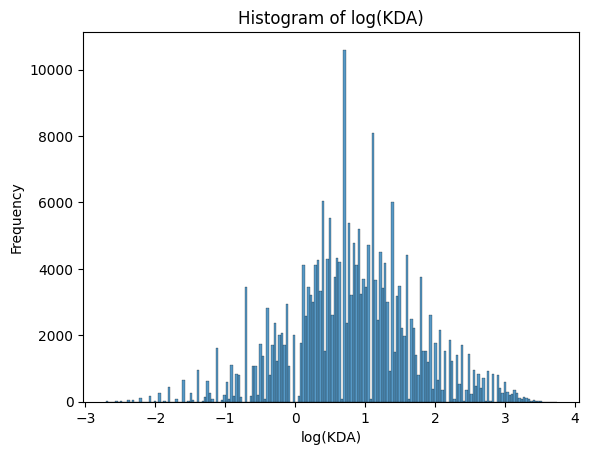

In [ ]:
# 로그 변환
log_kda = np.log(data['KDA'])

# 히스토그램 계산
counts, bin_edges = np.histogram(log_kda, bins='auto')

# 최대 빈도 수와 해당 빈도가 발생하는 도수 범위 찾기
max_count = counts.max()
max_index = counts.argmax()
max_bin_range = (bin_edges[max_index], bin_edges[max_index + 1])

print(f"Maximum count: {max_count}")
print(f"Bin range with maximum count: {max_bin_range}")

# 히스토그램 그리기
sns.histplot(log_kda, bins='auto')
plt.title('Histogram of log(KDA)')
plt.xlabel('log(KDA)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
data['KDA'] = np.log(data['KDA'])

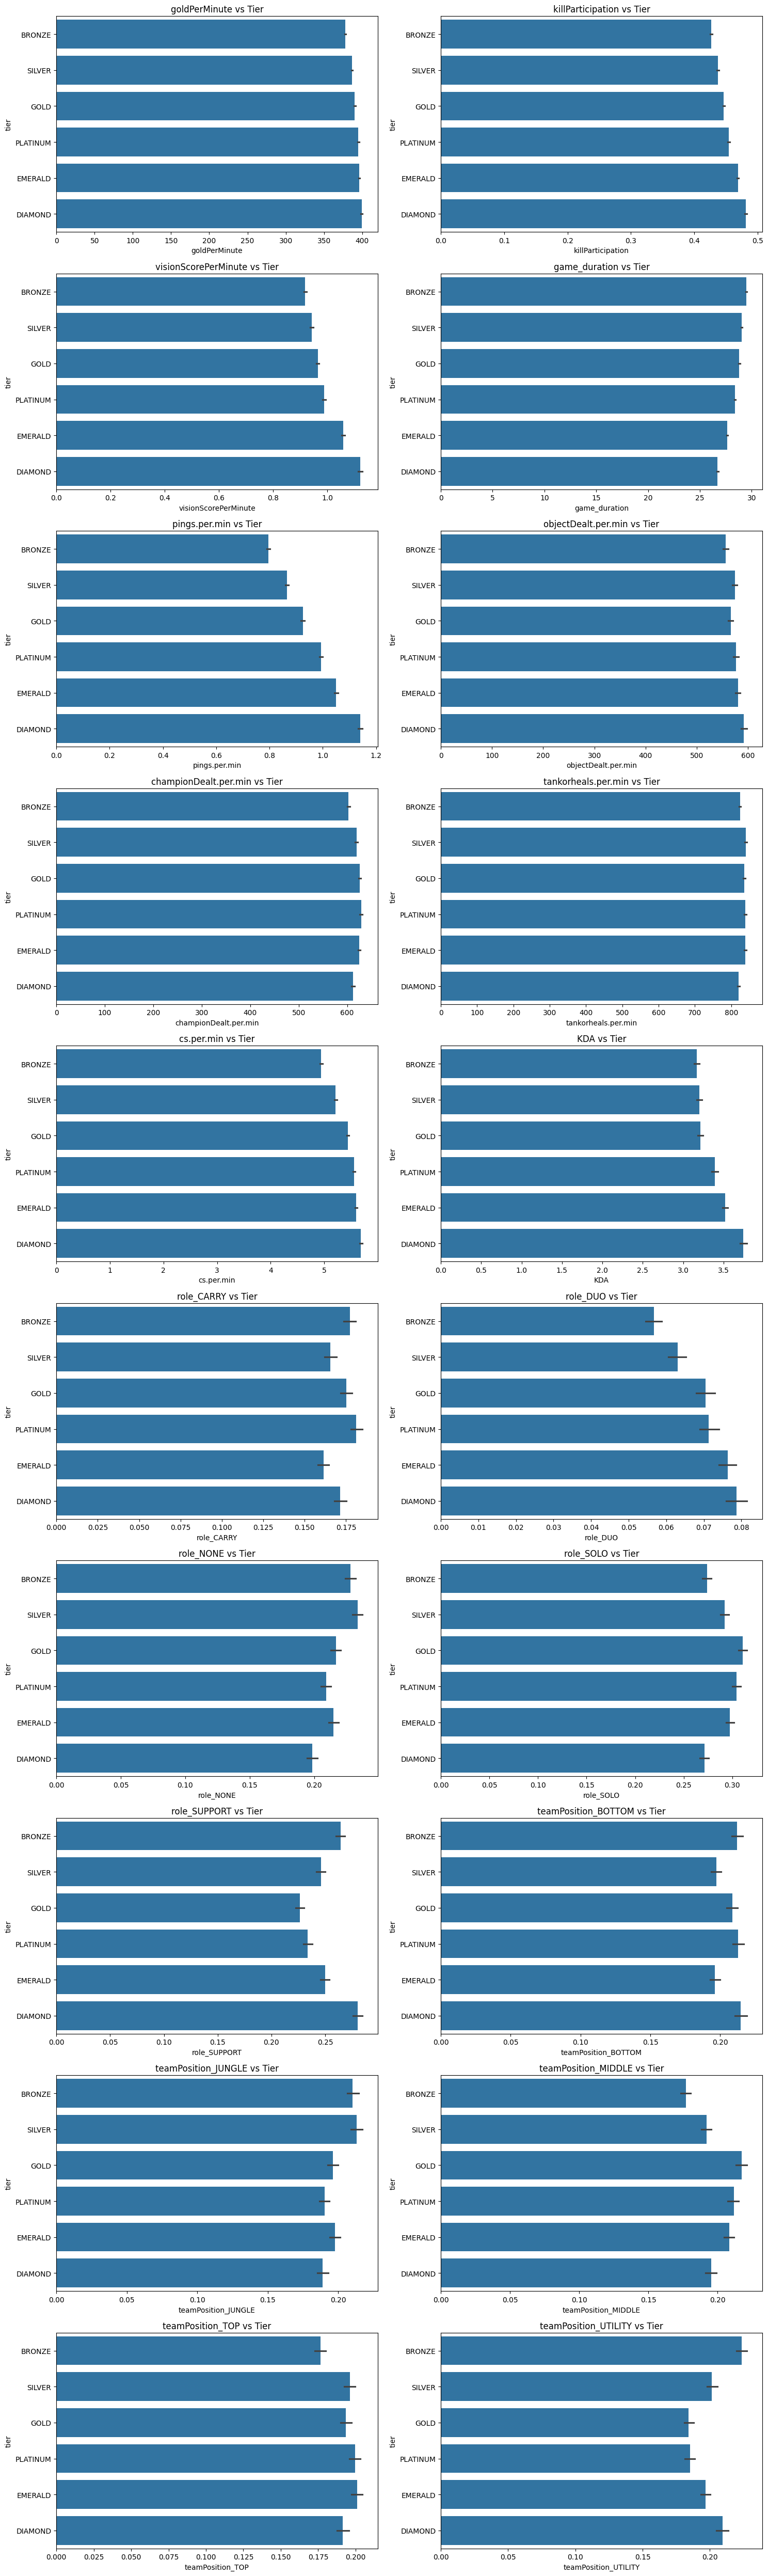

In [ ]:
variables = [col for col in data.columns if col != 'tier']
fig, axes = plt.subplots(10, 2, figsize=(15, 10 * 5))
axes = axes.flatten()

for idx, i in enumerate(variables):
    if i != 'tier':
        sns.barplot(x=data[i], y=data['tier'], order=tier_order, ax=axes[idx])
        axes[idx].set_title(f'{i} vs Tier')
    else : continue

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='objectDealt.per.min', ylabel='tier'>

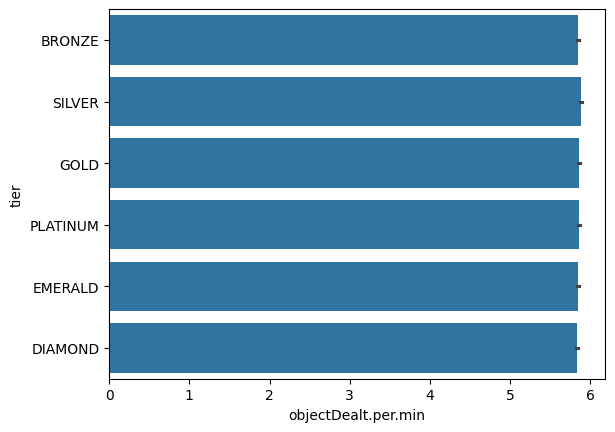

In [ ]:
sns.barplot(x=np.log(data['objectDealt.per.min']), y=data['tier'], order=tier_order)

<Axes: xlabel='objectDealt.per.min', ylabel='tier'>

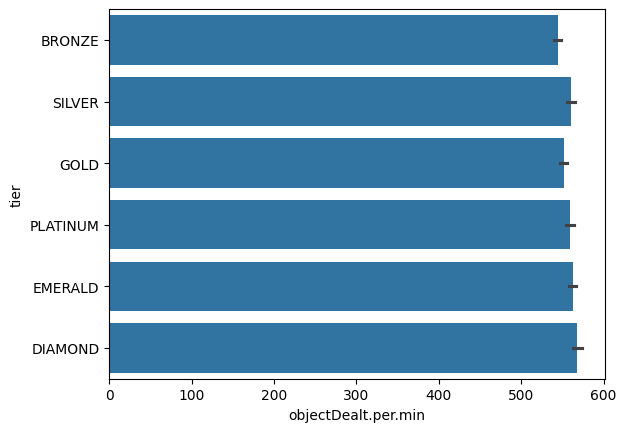

In [ ]:
sns.barplot(x=(data['objectDealt.per.min']), y=data['tier'], order=tier_order)

In [ ]:
data.isna().sum()

,0
goldPerMinute,0
killParticipation,0
visionScorePerMinute,0
game_duration,0
pings.per.min,0
objectDealt.per.min,0
championDealt.per.min,0
tankorheals.per.min,0
cs.per.min,0
KDA,0


<Axes: >

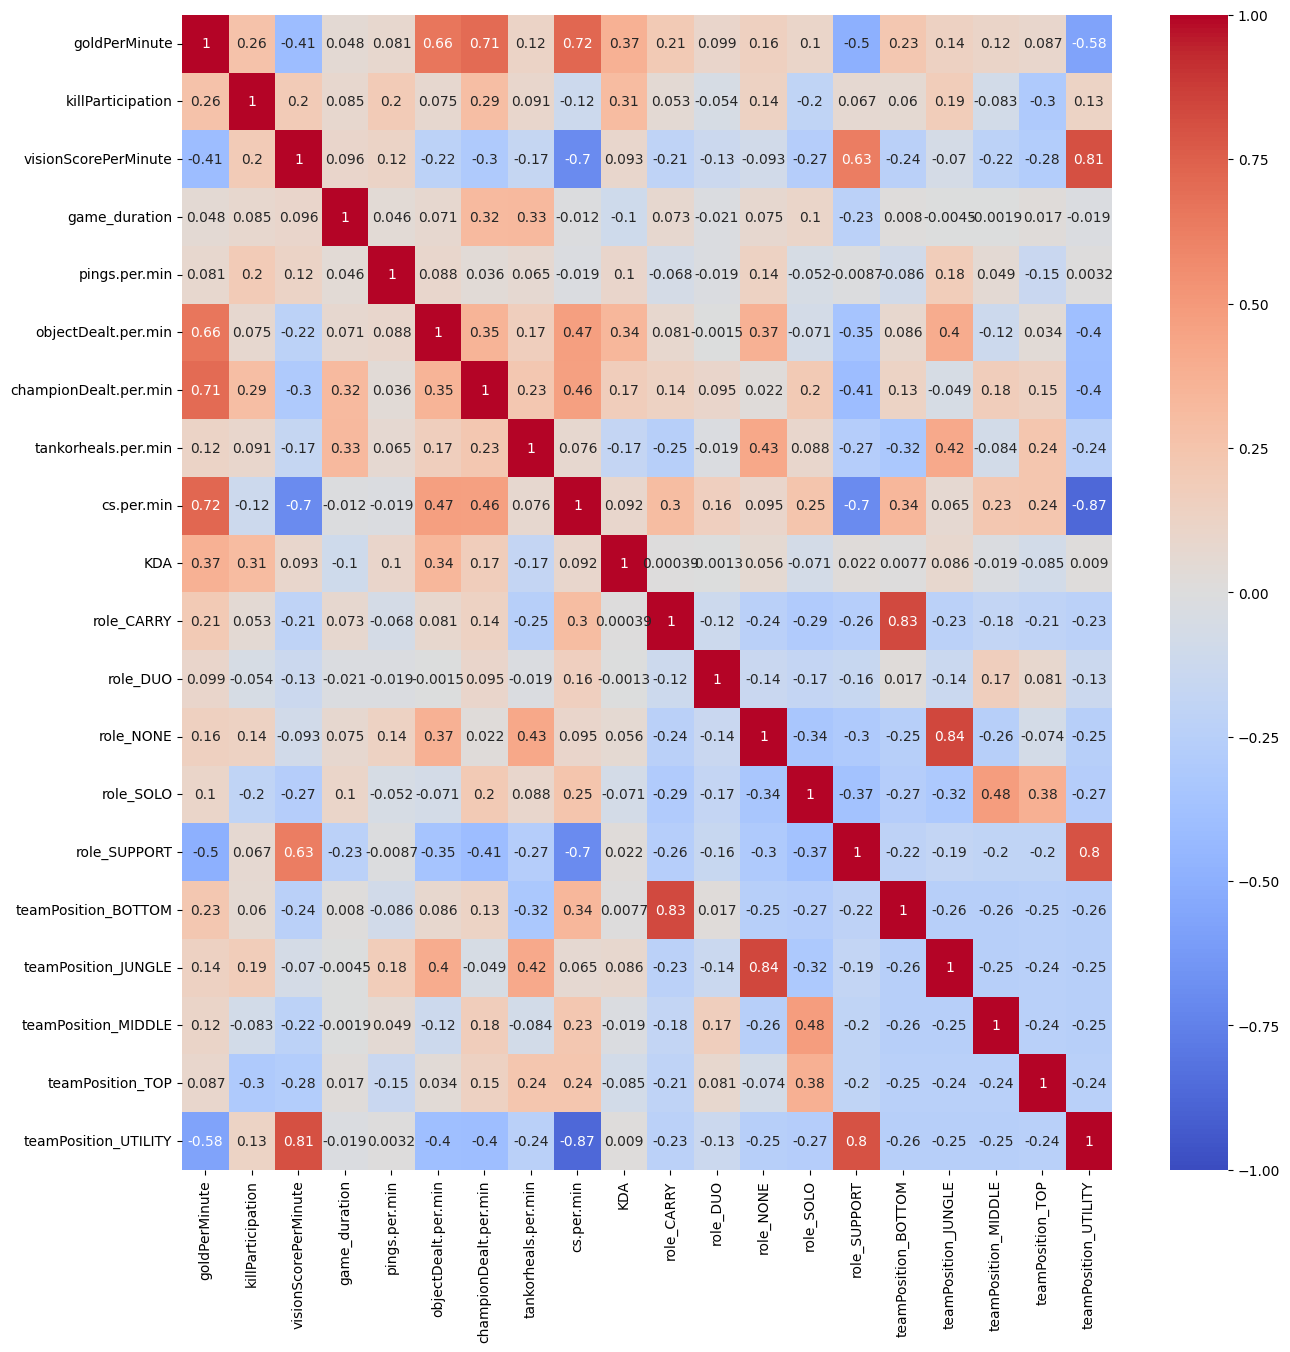

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr(numeric_only=True),cmap='coolwarm',vmax=1,vmin=-1,annot=True)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
# boolean 전부 실수형으로
bool_columns = data.select_dtypes(include='bool').columns
data[bool_columns] = data[bool_columns].astype(float)
print(data.dtypes)

goldPerMinute            float64
killParticipation        float64
visionScorePerMinute     float64
game_duration            float64
pings.per.min            float64
objectDealt.per.min      float64
championDealt.per.min    float64
tankorheals.per.min      float64
cs.per.min               float64
KDA                      float64
tier                      object
role_CARRY               float64
role_DUO                 float64
role_NONE                float64
role_SOLO                float64
role_SUPPORT             float64
teamPosition_BOTTOM      float64
teamPosition_JUNGLE      float64
teamPosition_MIDDLE      float64
teamPosition_TOP         float64
teamPosition_UTILITY     float64
dtype: object


In [ ]:
len(data['tier'])

257789

In [ ]:
# 'tier' 컬럼을 제외한 데이터프레임 생성
data_no_tier = data.drop(columns=['tier'])
X = data_no_tier.values
vif_data = pd.DataFrame()
vif_data["feature"] = data_no_tier.columns

In [ ]:
vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
print(vif_data)

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                  feature       VIF
0       killParticipation  1.633839
1    visionScorePerMinute  3.405290
2           game_duration  1.537427
3           pings.per.min  1.103963
4     objectDealt.per.min  1.990112
5   championDealt.per.min  2.067489
6     tankorheals.per.min  1.972053
7              cs.per.min  5.869232
8                     KDA  1.424515
9              role_CARRY       inf
10               role_DUO       inf
11              role_NONE       inf
12              role_SOLO       inf
13           role_SUPPORT       inf
14    teamPosition_BOTTOM       inf
15    teamPosition_JUNGLE       inf
16    teamPosition_MIDDLE       inf
17       teamPosition_TOP       inf
18   teamPosition_UTILITY       inf


In [ ]:
# 스케일링
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [ ]:
standard_scaler = StandardScaler()
scaled_data = standard_scaler.fit_transform(data.drop('tier',axis=1))


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(scaled_data,data['tier'],test_size=0.2,random_state=2024)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# train_test_split(독립변수,종속변수,테스트사이즈,시드값)
X_train, X_test, y_train, y_test = train_test_split(data.drop('tier',axis=1), data['tier'], test_size=0.2,shuffle=True, random_state=2023)


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(224249, 20)
(56063, 20)
(224249,)
(56063,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(random_state=2023)

In [ ]:
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=2023)

In [ ]:
pred1 = rf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

In [ ]:
accuracy_score(y_test,pred1)

0.5041292831279097

In [ ]:
print(classification_report(y_test,pred1))

              precision    recall  f1-score   support

           0       0.53      0.60      0.56      9014
           1       0.48      0.51      0.50      8462
           2       0.48      0.56      0.52     10300
           3       0.54      0.50      0.52      9723
           4       0.50      0.38      0.43      9138
           5       0.50      0.47      0.49      9426

    accuracy                           0.50     56063
   macro avg       0.50      0.50      0.50     56063
weighted avg       0.50      0.50      0.50     56063



In [ ]:
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
# params = {
#     'max_depth' : [30,40,50],
#     'min_samples_split' : [2,3,4],
#     'n_estimators' : [100,120,140]
# }

In [ ]:
# rf2 = RandomForestClassifier(random_state=2023)
# # grid_df = GridSearchCV(rf2,params,cv=5)
# grid_df = GridSearchCV(rf2,params)
# grid_df.fit(X_train,y_train)
# 시간;

KeyboardInterrupt: 

In [ ]:
# grid_df.best_params_

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report

In [ ]:
# 2. XGBoost
xgb_model = xgb.XGBClassifier(random_state=2023)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

print("XGBoost Report:")
print(classification_report(y_test, xgb_predictions))
print(f"Accuracy: {accuracy_score(y_test, xgb_predictions):.4f}\n")

XGBoost Report:
              precision    recall  f1-score   support

           0       0.35      0.45      0.39      9014
           1       0.34      0.36      0.35      8462
           2       0.28      0.40      0.33     10300
           3       0.26      0.20      0.23      9723
           4       0.26      0.14      0.18      9138
           5       0.27      0.24      0.25      9426

    accuracy                           0.30     56063
   macro avg       0.29      0.30      0.29     56063
weighted avg       0.29      0.30      0.29     56063

Accuracy: 0.2980



In [ ]:
!pip install lightgbm

In [ ]:
# 3. LightGBM
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(random_state=2023)
lgb_model.fit(X_train, y_train)
lgb_predictions = lgb_model.predict(X_test)

print("LightGBM Report:")
print(classification_report(y_test, lgb_predictions))
print(f"Accuracy: {accuracy_score(y_test, lgb_predictions):.4f}\n")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.184642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2567
[LightGBM] [Info] Number of data points in the train set: 224249, number of used features: 20
[LightGBM] [Info] Start training from score -1.836095
[LightGBM] [Info] Start training from score -1.894458
[LightGBM] [Info] Start training from score -1.687401
[LightGBM] [Info] Start training from score -1.756711
[LightGBM] [Info] Start training from score -1.815965
[LightGBM] [Info] Start training from score -1.772727
LightGBM Report:
              precision    recall  f1-score   support

           0       0.33      0.46      0.39      9014
           1       0.33      0.37      0.35      8462
           2       0.25      0.40      0.31     10300
           3       0.25      0.16      0.20      9723
           4       0.24      0.09      0.13      9138
           5       0.24      0.21      0.23 

In [ ]:
# 변수 재선택 필요.

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['tier'] = label_encoder.fit_transform(data['tier'])
data['tier']

,tier
0,0
1,0
2,0
3,0
4,0
...,...
280307,5
280308,5
280309,5
280310,5


In [ ]:
data = data.drop(['objectDealt.per.min','championDealt.per.min','tankorheals.per.min'],axis=1)
data

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
X_train.shape

torch.Size([224249, 17])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('tier',axis=1), data['tier'], test_size=0.2,shuffle=True, random_state=2023)

In [ ]:
# train,test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    data1.drop('tier', axis=1),
    data1['tier'],
    test_size=0.2,
    shuffle=True,
    random_state=2023
)

# train에서 train, calidation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    shuffle=True,
    random_state=2023
)


In [ ]:
# 텐서변환을 위한 배열
numpy_array1 = X_train.to_numpy()
numpy_array2 = X_test.to_numpy()
numpy_array3 = y_train.to_numpy()
numpy_array4 = y_test.to_numpy()
numpy_array5 = X_val.to_numpy()
numpy_array6 = y_val.to_numpy()

In [ ]:
# 텐서변환
X_train = torch.tensor(numpy_array1, dtype=torch.float32)
X_test = torch.tensor(numpy_array2, dtype=torch.float32)
y_train = torch.tensor(numpy_array3, dtype=torch.long)
y_test = torch.tensor(numpy_array4, dtype=torch.long)
X_val = torch.tensor(numpy_array5, dtype=torch.float32)
y_val = torch.tensor(numpy_array6, dtype=torch.long)

In [ ]:
# 데이터셋 생성
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False) #, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) #, drop_last=True)

In [ ]:
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset

# 딥러닝 모델 정의
class ClassificationModel(nn.Module):
    def __init__(self):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(17, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 6)  # 최종 6개

        # ReLU
        self.relu = nn.ReLU()

        # 드롭아웃
        self.dropout = nn.Dropout(0.5)

        # 배치 정규화
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.batch_norm2 = nn.BatchNorm1d(256)
        self.batch_norm3 = nn.BatchNorm1d(128)
        self.batch_norm4 = nn.BatchNorm1d(64)
        self.batch_norm5 = nn.BatchNorm1d(32)
        self.batch_norm6 = nn.BatchNorm1d(16)

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.batch_norm2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.batch_norm3(self.fc3(x)))
        x = self.dropout(x)
        x = self.relu(self.batch_norm4(self.fc4(x)))
        x = self.dropout(x)
        x = self.relu(self.batch_norm5(self.fc5(x)))
        x = self.dropout(x)
        x = self.relu(self.batch_norm6(self.fc6(x)))
        x = self.dropout(x)
        x = self.fc7(x)
        return x


model = ClassificationModel()
criterion = nn.CrossEntropyLoss() # 크로스엔트로피
optimizer = optim.Adam(model.parameters(), lr=0.001) # 아담
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
# 에폭
epochs = 10000


In [ ]:
# 학습 루프
for epoch in range(epochs):
    model.train()  # 모델을 훈련 모드로 설정
    optimizer.zero_grad()  # 기울기 초기화

    # 배치 데이터에 대해 학습 수행
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)  # 모델 예측
        loss = criterion(y_pred, y_batch)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 옵티마이저 단계

    # 학습률 스케줄러 스텝
    scheduler.step()

    # 매 100 에폭마다 손실 및 정확도 출력
    if epoch % 100 == 0:
        with torch.no_grad():
            model.eval()  # 모델을 평가 모드로 설정

            # 검증 데이터 평가
            val_correct = 0
            val_total = 0
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                _, predicted = torch.max(y_pred, 1)  # 최대값의 인덱스를 예측 결과로 사용
                val_total += y_batch.size(0)
                val_correct += (predicted == y_batch).sum().item()

            val_accuracy = (val_correct / val_total) * 100

            # 테스트 데이터 평가
            test_correct = 0
            test_total = 0
            for X_batch, y_batch in test_loader:
                y_pred = model(X_batch)
                _, predicted = torch.max(y_pred, 1)  # 최대값의 인덱스를 예측 결과로 사용
                test_total += y_batch.size(0)
                test_correct += (predicted == y_batch).sum().item()

            test_accuracy = (test_correct / test_total) * 100

            print(f'Epoch {epoch+1:4d}/{epochs} Loss: {loss.item():.6f} '
                  f'Val Accuracy: {val_accuracy:.2f}% Test Accuracy: {test_accuracy:.2f}%')

# 결과 정확도 저조 최적 Loss값 못찾음 구간에 갇혀서 발산수렴반복

Epoch    1/10000 Loss: 1.765335 Val Accuracy: 15.67% Test Accuracy: 16.04%


In [ ]:
# # 하이퍼파라미터
# epochs = 5000

# # 학습 루프
# for epoch in range(epochs + 1):
#     model.train()  # 모델을 훈련 모드로 설정
#     optimizer.zero_grad()  # 기울기 초기화

#     # 모델 예측
#     y_pred = model(X_train)  # X는 입력 데이터 텐서

#     # 손실 계산
#     loss = criterion(y_pred, y_train)  # y는 정수형 레이블 텐서 (0~5)

#     # 역전파 및 옵티마이저 단계
#     loss.backward()
#     optimizer.step()

#     if epoch % 100 == 0:  # 에폭을 1로 설정하여 매 에폭마다 결과를 출력
#         # 정확도 계산
#         with torch.no_grad():
#             model.eval()  # 모델을 평가 모드로 설정
#             y_pred_test = model(X_test)
#             _, predicted = torch.max(y_pred_test, 1)  # 최대값의 인덱스를 예측 결과로 사용
#             correct = (predicted == y_test).sum().item()
#             accuracy = (correct / len(y_test)) * 100
#             print(f'Epoch {epoch:4d}/{epochs} Loss: {loss.item():.6f} Accuracy: {accuracy:.2f}%')

# # 배치 설정 없이 했을 때. 비슷함.

Epoch    0/5000 Loss: 1.737958 Accuracy: 23.52%
Epoch  100/5000 Loss: 1.727393 Accuracy: 24.09%
Epoch  200/5000 Loss: 1.723952 Accuracy: 24.25%
Epoch  300/5000 Loss: 1.720606 Accuracy: 24.50%
Epoch  400/5000 Loss: 1.718966 Accuracy: 24.59%
Epoch  500/5000 Loss: 1.717067 Accuracy: 24.71%


KeyboardInterrupt: 

### **파이참(GPU를 사용한 MLP)**

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# from sklearn.metrics import classification_report
# import xgboost as xgb
# import lightgbm as lgb
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.optim import lr_scheduler
# from torch.utils.data import DataLoader, TensorDataset
# import torch

# # GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")


# # 데이터 불러오기
# data = pd.read_csv("./data/data.csv")

# # print(data.head())

# # 타겟 데이터 범주형 변수로 변환
# data['tier'] = data['changed_rank'].apply(lambda x: 'BRONZE' if 980.9229 <= x <= 1386.7672
#                                           else 'SILVER' if 1386.7672 < x <= 1792.6115
#                                           else 'GOLD' if 1792.6115 < x <= 2198.4558
#                                           else 'PLATINUM' if 2198.4558 < x <= 2604.3001
#                                           else 'EMERALD' if 2604.3001 < x <= 3010.1444
#                                           else 'DIAMOND')

# data = data.drop(['changed_rank'],axis=1)
# # data = data.drop(['objectDealt.per.min','championDealt.per.min','tankorheals.per.min'],axis=1)
# # print(data['tier'])

# # 원핫 인코딩 진행
# list = ['teamPosition','role']
# # print(list)

# data = pd.get_dummies(data,columns=list)
# # print(data)

# # 서포터가 아니면서 cs.per.min 값이 2.5 이하인 데이터
# condition_to_drop = (data['teamPosition_UTILITY'] == 0) & (data['cs.per.min'] <= 2.5)
# index_to_drop = data[condition_to_drop].index
# # 해당 인덱스의 삭제
# data = data.drop(index_to_drop)

# # print(data.shape)

# np.random.seed(2023)
# filtered_data = data[data['game_duration'] <= 17]
# sampled_data = filtered_data.sample(n=4000, random_state=2023)
# data = pd.concat([data[~data.index.isin(filtered_data.index)], sampled_data])

# # print(f"Updated data shape: {data.shape}")

# log_kda = np.log(data['KDA'])
# counts, bin_edges = np.histogram(log_kda, bins='auto')
# max_count = counts.max()
# max_index = counts.argmax()
# max_bin_range = (bin_edges[max_index], bin_edges[max_index + 1])

# filtered_data = data[(log_kda >= max_bin_range[0]) & (log_kda < max_bin_range[1])]

# if len(filtered_data) > 2000:
#     sampled_data = filtered_data.sample(n=2000, random_state=2023)
# else:
#     sampled_data = filtered_data  # 데이터가 2000개 이하인 경우 전체 데이터 사용
#
# data = pd.concat([data[~data.index.isin(filtered_data.index)], sampled_data])
# # print(f"New data shape: {data.shape}")

# data['KDA'] = np.log(data['KDA'])


# # 종속변수 라벨 인코딩

# label_encoder = LabelEncoder()
# data['tier'] = label_encoder.fit_transform(data['tier'])
# # print(data['tier'])

# 스케일러
# standard_scaler = StandardScaler()
# scaled_data = standard_scaler.fit_transform(data.drop('tier',axis=1))


# # boolean 전부 실수형으로
# bool_columns = data.select_dtypes(include='bool').columns
# data[bool_columns] = data[bool_columns].astype(float)
# # print(data.dtypes)

# X_train, X_test, y_train, y_test = train_test_split(data.drop('tier',axis=1), data['tier'], test_size=0.2,shuffle=True, random_state=2023)


# X_train_full, X_test, y_train_full, y_test = train_test_split(
#     data.drop('tier', axis=1),
#     data['tier'],
#     test_size=0.2,
#     shuffle=True,
#     random_state=2023
# )

# X_train, X_val, y_train, y_val = train_test_split(
#     X_train_full,
#     y_train_full,
#     test_size=0.2,
#     shuffle=True,
#     random_state=2023
# )

# print(X_train.shape)
# print(X_test.shape)
# print(X_val.shape)
# print(y_train.shape)
# print(y_test.shape)
# print(y_val.shape)

In [ ]:
# # 텐서형으로 변환을 위한 배열 정리
# numpy_array1 = X_train.to_numpy()
# numpy_array2 = X_test.to_numpy()
# numpy_array3 = y_train.to_numpy()
# numpy_array4 = y_test.to_numpy()
# numpy_array5 = X_val.to_numpy()
# numpy_array6 = y_val.to_numpy()

# # 탠서변환
# X_train = torch.tensor(numpy_array1, dtype=torch.float32)
# X_test = torch.tensor(numpy_array2, dtype=torch.float32)
# y_train = torch.tensor(numpy_array3, dtype=torch.long)
# y_test = torch.tensor(numpy_array4, dtype=torch.long)
# X_val = torch.tensor(numpy_array5, dtype=torch.float32)
# y_val = torch.tensor(numpy_array6, dtype=torch.long)

# # 데이터셋 생성
# train_dataset = TensorDataset(X_train, y_train)
# val_dataset = TensorDataset(X_val, y_val)
# test_dataset = TensorDataset(X_test, y_test)

# def move_to_device(batch):
#     X_batch, y_batch = zip(*batch)
#     X_batch = torch.stack([x.to(device) for x in X_batch])
#     y_batch = torch.tensor(y_batch, dtype=torch.long).to(device)
#     return X_batch, y_batch

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True, collate_fn=move_to_device)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=True, collate_fn=move_to_device)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True, collate_fn=move_to_device)

# # 딥러닝 모델
# class ClassificationModel(nn.Module):
#     def __init__(self):
#         super(ClassificationModel, self).__init__()
#         self.fc1 = nn.Linear(20, 4096)
#         self.fc2 = nn.Linear(4096, 2048)
#         self.fc3 = nn.Linear(2048, 1024)
#         self.fc4 = nn.Linear(1024, 512)
#         self.fc5 = nn.Linear(512, 256)
#         self.fc6 = nn.Linear(256, 128)
#         self.fc7 = nn.Linear(128, 64)
#         self.fc8 = nn.Linear(64, 32)
#         self.fc9 = nn.Linear(32, 16)
#         self.fc10 = nn.Linear(16, 8)
#         self.fc11 = nn.Linear(8, 6)  # 최종 6개 클래스

#         # ReLU 활성화 함수
#         self.relu = nn.ReLU()

#         # 드롭아웃
#         self.dropout = nn.Dropout(0.3)

#         # 배치 정규화
#         self.batch_norm1 = nn.BatchNorm1d(4096)
#         self.batch_norm2 = nn.BatchNorm1d(2048)
#         self.batch_norm3 = nn.BatchNorm1d(1024)
#         self.batch_norm4 = nn.BatchNorm1d(512)
#         self.batch_norm5 = nn.BatchNorm1d(256)
#         self.batch_norm6 = nn.BatchNorm1d(128)
#         self.batch_norm7 = nn.BatchNorm1d(64)
#         self.batch_norm8 = nn.BatchNorm1d(32)
#         self.batch_norm9 = nn.BatchNorm1d(16)
#         self.batch_norm10 = nn.BatchNorm1d(8)

#     def forward(self, x):
#         x = self.relu(self.batch_norm1(self.fc1(x)))
#         x = self.dropout(x)
#         x = self.relu(self.batch_norm2(self.fc2(x)))
#         x = self.dropout(x)
#         x = self.relu(self.batch_norm3(self.fc3(x)))
#         x = self.dropout(x)
#         x = self.relu(self.batch_norm4(self.fc4(x)))
#         x = self.dropout(x)
#         x = self.relu(self.batch_norm5(self.fc5(x)))
#         x = self.dropout(x)
#         x = self.relu(self.batch_norm6(self.fc6(x)))
#         x = self.dropout(x)
#         x = self.relu(self.batch_norm7(self.fc7(x)))
#         x = self.dropout(x)
#         x = self.relu(self.batch_norm8(self.fc8(x)))
#         x = self.dropout(x)
#         x = self.relu(self.batch_norm9(self.fc9(x)))
#         x = self.dropout(x)
#         x = self.relu(self.batch_norm10(self.fc10(x)))
#         x = self.dropout(x)
#         x = self.fc11(x)
#         return x



# # GPU로
# model = ClassificationModel().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.00001)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
# epochs = 200

# # 학습
# for epoch in range(epochs):
#     model.train()
#     optimizer.zero_grad()

#     # 배치 데이터에 대해 학습 수행
#     for X_batch, y_batch in train_loader:
#         X_batch = X_batch.to(device)
#         y_batch = y_batch.to(device)

#         y_pred = model(X_batch)
#         loss = criterion(y_pred, y_batch)
#         loss.backward()
#         optimizer.step()

#     scheduler.step()

#     # 매 에폭마다 손실 및 정확도 출력
#     if epoch % 1 == 0:
#         with torch.no_grad():
#             model.eval()

#             val_correct = 0
#             val_total = 0
#             for X_batch, y_batch in val_loader:
#                 X_batch = X_batch.to(device)
#                 y_batch = y_batch.to(device)

#                 y_pred = model(X_batch)
#                 _, predicted = torch.max(y_pred, 1)
#                 val_total += y_batch.size(0)
#                 val_correct += (predicted == y_batch).sum().item()

#             val_accuracy = (val_correct / val_total) * 100

#             test_correct = 0
#             test_total = 0
#             for X_batch, y_batch in test_loader:
#                 X_batch = X_batch.to(device)
#                 y_batch = y_batch.to(device)

#                 y_pred = model(X_batch)
#                 _, predicted = torch.max(y_pred, 1)
#                 test_total += y_batch.size(0)
#                 test_correct += (predicted == y_batch).sum().item()

#             test_accuracy = (test_correct / test_total) * 100

#             print(f'Epoch {epoch + 1:4d}/{epochs} Loss: {loss.item():.6f} '
#                   f'Val Accuracy: {val_accuracy:.2f}% Test Accuracy: {test_accuracy:.2f}%')

In [ ]:
# Using device: cuda
# (159169, 20)
# (49741, 20)
# (39793, 20)
# (159169,)
# (49741,)
# (39793,)
# Epoch    1/200 Loss: 1.811952 Val Accuracy: 16.38% Test Accuracy: 16.37%
# Epoch    2/200 Loss: 1.795802 Val Accuracy: 16.12% Test Accuracy: 16.21%
# Epoch    3/200 Loss: 1.789276 Val Accuracy: 18.45% Test Accuracy: 18.33%
# Epoch    4/200 Loss: 1.780264 Val Accuracy: 18.72% Test Accuracy: 18.81%
# Epoch    5/200 Loss: 1.765045 Val Accuracy: 19.16% Test Accuracy: 19.44%
# Epoch    6/200 Loss: 1.770695 Val Accuracy: 20.40% Test Accuracy: 20.50%
# Epoch    7/200 Loss: 1.770125 Val Accuracy: 20.23% Test Accuracy: 20.31%
# Epoch    8/200 Loss: 1.770433 Val Accuracy: 20.71% Test Accuracy: 20.80%
# Epoch    9/200 Loss: 1.738616 Val Accuracy: 21.52% Test Accuracy: 21.45%
# Epoch   10/200 Loss: 1.721950 Val Accuracy: 21.52% Test Accuracy: 21.49%
# Epoch   11/200 Loss: 1.776182 Val Accuracy: 21.89% Test Accuracy: 21.79%
# Epoch   12/200 Loss: 1.887852 Val Accuracy: 22.62% Test Accuracy: 22.35%
# Epoch   13/200 Loss: 1.747969 Val Accuracy: 22.63% Test Accuracy: 22.52%
# Epoch   14/200 Loss: 1.806393 Val Accuracy: 22.83% Test Accuracy: 22.83%
# Epoch   15/200 Loss: 1.828300 Val Accuracy: 23.34% Test Accuracy: 23.03%
# Epoch   16/200 Loss: 1.807903 Val Accuracy: 23.42% Test Accuracy: 23.44%
# Epoch   17/200 Loss: 1.747516 Val Accuracy: 23.79% Test Accuracy: 23.56%
# Epoch   18/200 Loss: 1.751521 Val Accuracy: 23.41% Test Accuracy: 23.43%
# Epoch   19/200 Loss: 1.791813 Val Accuracy: 24.00% Test Accuracy: 23.88%
# Epoch   20/200 Loss: 1.763119 Val Accuracy: 23.81% Test Accuracy: 23.62%
# Epoch   21/200 Loss: 1.739420 Val Accuracy: 24.46% Test Accuracy: 24.38%
# Epoch   22/200 Loss: 1.819167 Val Accuracy: 24.23% Test Accuracy: 24.11%
# Epoch   23/200 Loss: 1.708763 Val Accuracy: 24.52% Test Accuracy: 24.05%
# Epoch   24/200 Loss: 1.846381 Val Accuracy: 24.78% Test Accuracy: 24.53%
# Epoch   25/200 Loss: 1.691497 Val Accuracy: 24.54% Test Accuracy: 24.37%
# Epoch   26/200 Loss: 1.808558 Val Accuracy: 24.64% Test Accuracy: 24.28%
# Epoch   27/200 Loss: 1.730428 Val Accuracy: 24.69% Test Accuracy: 24.49%
# Epoch   28/200 Loss: 1.816351 Val Accuracy: 24.90% Test Accuracy: 24.66%
# Epoch   29/200 Loss: 1.694364 Val Accuracy: 24.93% Test Accuracy: 24.61%
# Epoch   30/200 Loss: 1.619371 Val Accuracy: 24.77% Test Accuracy: 24.34%
# Epoch   31/200 Loss: 1.709455 Val Accuracy: 24.74% Test Accuracy: 24.68%
# Epoch   32/200 Loss: 1.712560 Val Accuracy: 25.01% Test Accuracy: 24.82%
# Epoch   33/200 Loss: 1.734505 Val Accuracy: 24.96% Test Accuracy: 24.39%
# Epoch   34/200 Loss: 1.729471 Val Accuracy: 25.26% Test Accuracy: 24.94%
# Epoch   35/200 Loss: 1.711981 Val Accuracy: 25.19% Test Accuracy: 24.62%
# Epoch   36/200 Loss: 1.689825 Val Accuracy: 24.95% Test Accuracy: 24.95%
# Epoch   37/200 Loss: 1.618420 Val Accuracy: 25.38% Test Accuracy: 24.92%
# Epoch   38/200 Loss: 1.784734 Val Accuracy: 24.94% Test Accuracy: 24.92%
# Epoch   39/200 Loss: 1.827997 Val Accuracy: 25.31% Test Accuracy: 25.16%
# Epoch   40/200 Loss: 1.650418 Val Accuracy: 25.32% Test Accuracy: 25.30%
# Epoch   41/200 Loss: 1.683987 Val Accuracy: 25.31% Test Accuracy: 25.09%
# Epoch   42/200 Loss: 1.711032 Val Accuracy: 25.22% Test Accuracy: 25.15%

# 비슷함. 변수 재선택 필요